In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import jaccard_score

from pystruct.datasets import load_letters
from pystruct.models import ChainCRF
from pystruct.learners import FrankWolfeSSVM, OneSlackSSVM, NSlackSSVM, StructuredPerceptron

import pandas as pd

from tqdm.notebook import tqdm

from sklearn.model_selection import KFold

from nltk import ngrams

## Feature Extraction

In [2]:
frequencies = pd.read_csv("./Anchor_pos_data/mhcflurry.ba.frequency_matrices.csv")
frequencies = frequencies[(frequencies['cutoff_fraction'] == 0.01)]
frequencies['X'] = np.zeros(frequencies.shape[0])
frequencies_alleles = pd.unique(frequencies['allele'])

In [3]:
frequencies

,allele,length,cutoff_fraction,cutoff_count,position,A,C,D,E,F,...,N,P,Q,R,S,T,V,W,Y,X
16,Atbe-B*01:01,8,0.01,999,1,0.078078,0.001001,0.006006,0.024024,0.081081,...,0.015015,0.001001,0.022022,0.066066,0.131131,0.086086,0.132132,0.000000,0.082082,0.0
17,Atbe-B*01:01,8,0.01,999,2,0.158158,0.000000,0.000000,0.001001,0.010010,...,0.004004,0.000000,0.007007,0.000000,0.144144,0.248248,0.165165,0.000000,0.001001,0.0
18,Atbe-B*01:01,8,0.01,999,3,0.079079,0.003003,0.127127,0.016016,0.132132,...,0.038038,0.073073,0.018018,0.011011,0.067067,0.019019,0.053053,0.032032,0.084084,0.0
19,Atbe-B*01:01,8,0.01,999,4,0.077077,0.001001,0.047047,0.092092,0.035035,...,0.025025,0.165165,0.029029,0.027027,0.057057,0.048048,0.076076,0.007007,0.016016,0.0
20,Atbe-B*01:01,8,0.01,999,5,0.078078,0.002002,0.011011,0.011011,0.102102,...,0.019019,0.174174,0.016016,0.013013,0.039039,0.045045,0.107107,0.013013,0.037037,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2953625,Sasc-G*04:01,15,0.01,1000,11,0.074000,0.004000,0.093000,0.086000,0.014000,...,0.083000,0.045000,0.028000,0.030000,0.115000,0.046000,0.066000,0.010000,0.003000,0.0
2953626,Sasc-G*04:01,15,0.01,1000,12,0.076000,0.007000,0.086000,0.069000,0.013000,...,0.082000,0.062000,0.043000,0.020000,0.115000,0.052000,0.047000,0.010000,0.008000,0.0
2953627,Sasc-G*04:01,15,0.01,1000,13,0.129000,0.011000,0.065000,0.065000,0.019000,...,0.065000,0.035000,0.045000,0.023000,0.116000,0.065000,0.053000,0.007000,0.014000,0.0
2953628,Sasc-G*04:01,15,0.01,1000,14,0.121000,0.010000,0.044000,0.072000,0.021000,...,0.053000,0.044000,0.038000,0.035000,0.134000,0.076000,0.052000,0.010000,0.008000,0.0


In [4]:
dataset = pd.read_csv("./Anchor_pos_data/Template_information.csv")
dataset = dataset[(dataset['peptide_length'] > 7) & (dataset['MHC']).isin(frequencies_alleles)]
dataset = dataset[~dataset['pdb_code'].str.contains("_B.pdb")]
dataset["pdb_code"] = dataset["pdb_code"].str.replace("_A","")
MHC_list = dataset['MHC'].tolist()
peptide_list = dataset['peptide'].tolist()
labels_list = dataset['anchors'].tolist()
NetMHCpan_list = dataset['NetMHCpan4.1'].tolist()
lengths_list = dataset['peptide_length'].tolist()

In [5]:
dataset

,Unnamed: 0,pdb_code,MHC,peptide,peptide_length,anchors,NetMHCpan4.1
0,990,5XMM.pdb,BoLA-2*012:01,DMANVSTGR,9,"2,9","2, 9"
1,807,5XMF.pdb,BoLA-2*012:01,RMANVSTGR,9,"2,9","2, 9"
2,228,3PWV.pdb,BoLA-2*018:01,IPAYGVLTI,9,"2,9","2, 9"
3,1153,3PWU.pdb,BoLA-2*018:01,IPAYGVLTI,9,"2,9","2, 9"
4,982,2XFX.pdb,BoLA-6*013:01,VGYPKVKEEML,11,"2,11","2, 11"
...,...,...,...,...,...,...,...
1171,779,5NQ3.pdb,SLA-1*14:02,EFEDLTFLA,9,"2,9","2, 9"
1172,1043,5NPZ.pdb,SLA-1*14:02,EFEDLTFLA,9,"2,9","2, 9"
1173,304,5YLX.pdb,SLA-1*15:01,TMPPGFELY,9,"2,9","2, 9"
1174,56,6A6H.pdb,SLA-2*04:02:01,MTAHIVVPY,9,"1,2,9","2, 9"


Change feature extraction features at will:

In [6]:
# Feature Extraction parameters
windows_size = 1
feature_size = 1

In [ ]:
def extract_positions(position, peptide, feature_size):
    scale = range(-int(np.floor(feature_size/2)), int(np.floor(feature_size/2)) + 1)
    position_list = []
    append_left = 0
    append_right = 0
    for x in scale:
        if (position + x < 1):
            position_list.append(0)
            append_left += 1
        elif (position + x > len(peptide)):
            position_list.append(0)
            append_right += 1
        else:
            position_list.append(position + x)
    return position_list, append_left, append_right

wind = int(np.floor(windows_size/2))
all_features_list = []
all_labels_list = []
all_labels_NetMHCpan_list = []
for i, peptide in enumerate(tqdm(peptide_list)):
    
    aa_neighbors = [''.join(w) for w in list(ngrams(peptide, windows_size, pad_left=True, pad_right=True, 
                                                    left_pad_symbol='X', 
                                                    right_pad_symbol='X'))][wind:]
    aa_neighbors = aa_neighbors[:len(aa_neighbors) - wind]
    
    sub_seq_feature_list = []
    for k, sub_seq in enumerate(aa_neighbors):
    
        # Break subsequence down to amino_acids
        pep_sequence = list(sub_seq)
        
        # For each amino-acid, extract frequencies and important positions
        feature_list = []
        for j, amino_acid in enumerate(pep_sequence):
        
            freq_features = frequencies[(frequencies['allele'] == MHC_list[i]) & (frequencies['length'] == lengths_list[i])]
            position_list, append_left, append_right = extract_positions(j + k + 1 - wind, peptide, feature_size)
            freq_features = freq_features[freq_features['position'].isin(position_list)][amino_acid].values
            freq_features = np.hstack([np.zeros(append_left), freq_features, np.zeros(append_right)])
            feature_list.append(freq_features) 
        
        features = np.array(np.hstack(feature_list))
        posn_feature = (k == 0)
        posnplus1_feature = (k == 1)
        posc_feature = (k == len(peptide) - 1) # Get those out!
        features = np.hstack([features, [posn_feature], [posnplus1_feature], [posc_feature]])
        sub_seq_feature_list.append(features)
    all_features_list.append(np.array(sub_seq_feature_list, dtype=np.float))
    
    labels_int_list = [int(x) - 1 for x in labels_list[i].split(',')]
    labels = np.zeros(len(peptide), dtype=int)
    labels[labels_int_list] = 1
    all_labels_list.append(labels)
    
    labels_NetMHCpan_int_list = [int(x) - 1 for x in NetMHCpan_list[i].split(',')]
    labels_NetMHCpan = np.zeros(len(peptide), dtype=int)
    labels_NetMHCpan[labels_NetMHCpan_int_list] = 1
    all_labels_NetMHCpan_list.append(labels_NetMHCpan)
    
X = np.array(all_features_list, dtype=object)
y = np.array(all_labels_list, dtype=object)
y_NetMHCpan = np.array(all_labels_NetMHCpan_list, dtype=object)

In [ ]:
def correct_predictions(y_test, preds):
    counter = 0
    correct = 0
    for i in range(y_test.shape[0]):
        correct += np.array_equal(y_test[i], preds[counter:(counter + y_test[i].shape[0])])
        counter += y_test[i].shape[0]

    # print(str(correct) + "/" + str(y_test.shape[0]) + " correct predictions!")
    return correct

In [ ]:
def jaccard_predictions(y_test, preds):
    counter = 0
    correct = 0
    for i in range(y_test.shape[0]):
        correct += jaccard_score(y_test[i], preds[counter:(counter + y_test[i].shape[0])])
        counter += y_test[i].shape[0]

    # print(str(correct) + "/" + str(y_test.shape[0]) + " correct predictions!")
    return correct

In [ ]:
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

In [ ]:
svm_preds = {}
svm_correct_predictions = []
svm_jaccard_predictions = []

rf_preds = {}
rf_correct_predictions = []
rf_jaccard_predictions = []

crf_preds = {}
crf_correct_predictions = []
crf_jaccard_predictions = []

sper_preds = {}
sper_correct_predictions = []
sper_jaccard_predictions = []

NetMHCpan_correct_predictions = []
NetMHCpan_jaccard_predictions = []

labels = {}

for i, (train_index, test_index) in enumerate(tqdm(kfold.split(X))):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    
    # Train linear SVM
    svm = LinearSVC(dual=False, C=.1)
    svm.fit(np.vstack(X_train), np.hstack(y_train))
    svm_preds[i] = svm.predict(np.vstack(X_test))
    svm_correct_predictions.append(correct_predictions(y_test, svm_preds[i]))
    svm_jaccard_predictions.append(jaccard_predictions(y_test, svm_preds[i]))
    
    # Train Random Forest
    rf = RandomForestClassifier(n_estimators=500, random_state=0)
    rf.fit(np.vstack(X_train), np.hstack(y_train))
    rf_preds[i] = rf.predict(np.vstack(X_test))
    rf_correct_predictions.append(correct_predictions(y_test, rf_preds[i]))
    rf_jaccard_predictions.append(jaccard_predictions(y_test, rf_preds[i]))
    
    # Train linear chain CRF
    model = ChainCRF()
    crf = FrankWolfeSSVM(model=model, C=.1, max_iter=20)
    crf.fit(X_train, y_train)
    crf_preds[i] = crf.predict(X_test)
    crf_correct_predictions.append(correct_predictions(y_test, np.hstack(crf_preds[i])))
    crf_jaccard_predictions.append(jaccard_predictions(y_test, np.hstack(crf_preds[i])))
    
    # Train Structured perceptron
    sper = StructuredPerceptron(model=model, max_iter=500)
    sper.fit(X_train, y_train)
    sper_preds[i] = sper.predict(X_test)
    sper_correct_predictions.append(correct_predictions(y_test, np.hstack(sper_preds[i])))
    sper_jaccard_predictions.append(jaccard_predictions(y_test, np.hstack(sper_preds[i])))
    
    y_test_NetMHcpan41 = y_NetMHCpan[test_index]
    NetMHCpan_correct_predictions.append(correct_predictions(y_test, np.hstack(y_test_NetMHcpan41)))
    NetMHCpan_jaccard_predictions.append(jaccard_predictions(y_test, np.hstack(y_test_NetMHcpan41)))
    
    labels[i] =  np.hstack(y_test)

In [ ]:
print('Exact Accuracies: ')
print('Linear SVM: ', str(sum(svm_correct_predictions)/dataset.shape[0]))
print('Random Forest: ', str(sum(rf_correct_predictions)/dataset.shape[0]))
print('Linear CRF: ',  str(sum(crf_correct_predictions)/dataset.shape[0]))
print('Structured Perceptron: ',  str(sum(sper_correct_predictions)/dataset.shape[0]))
print('NetMHCpan4.1: ',  str(sum(NetMHCpan_correct_predictions)/dataset.shape[0]))

print('\nJaccard Accuracies: ')
print('Linear SVM: ', str(sum(svm_jaccard_predictions)/dataset.shape[0]))
print('Random Forest: ', str(sum(rf_jaccard_predictions)/dataset.shape[0]))
print('Linear CRF: ',  str(sum(crf_jaccard_predictions)/dataset.shape[0]))
print('Structured Perceptron: ',  str(sum(sper_jaccard_predictions)/dataset.shape[0]))
print('NetMHCpan4.1: ',  str(sum(NetMHCpan_jaccard_predictions)/dataset.shape[0]))

# SINGLE CELL EXECUTION

In [13]:
for train_index, test_index in kfold.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

In [14]:
def correct_predictions(y_test, preds):
    counter = 0
    correct = 0
    for i in range(y_test.shape[0]):
        correct += np.array_equal(y_test[i], preds[counter:(counter + y_test[i].shape[0])])
        counter += y_test[i].shape[0]

    print(str(correct) + "/" + str(y_test.shape[0]) + " correct predictions!")

In [15]:
# Train linear SVM
svm = LinearSVC(dual=False, C=.1)

# flatten input
svm.fit(np.vstack(X_train), np.hstack(y_train))

print("Test score with linear SVM: %f" % svm.score(np.vstack(X_test), np.hstack(y_test)))

preds = svm.predict(np.vstack(X_test))
correct_predictions(y_test, preds)

Test score with linear SVM: 0.899431
39/114 correct predictions!


In [25]:
clf = RandomForestClassifier(n_estimators=1000, random_state=0)

clf.fit(np.vstack(X_train), np.hstack(y_train))

print("Test score with Random Forest: %f" % clf.score(np.vstack(X_test), np.hstack(y_test)))

preds = clf.predict(np.vstack(X_test))
correct_predictions(y_test, preds)

Test score with Random Forest: 0.963947
89/114 correct predictions!


In [26]:
test2 = list(zip(np.array(peptide_list)[list(test_index)].tolist(),
                 np.array(MHC_list)[list(test_index)].tolist()))
zipped_list = test2[:]
zipped_list_2 = np.array(test2)

counter = 0
for i in range(y_test.shape[0]):
    print(zipped_list_2[i])
    print(y_test[i])
    print(preds[counter:(counter + y_test[i].shape[0])])
    input()
    counter += y_test[i].shape[0]

['ASNENMETM' 'H2-Db']
[1 1 0 0 1 0 0 0 1]
[1 1 0 0 1 0 0 0 1]

['HPVGEADYFEY' 'HLA-B*35:01']
[0 0 0 0 0 0 0 0 0 0 1]
[0 0 0 0 0 0 0 0 0 0 1]

['RIIPRHLQL' 'Mamu-B*008:01:01:01']
[0 1 0 0 0 0 0 0 0]
[0 1 0 0 0 1 0 0 0]

['KLFSGELTK' 'HLA-A*11:183']
[0 1 0 0 0 0 0 0 1]
[0 1 0 0 0 0 0 0 1]

['YQFGPDFPIA' 'HLA-A*02:01']
[0 1 0 0 0 0 0 0 0 1]
[0 1 0 0 0 0 0 0 0 1]

['RFPLTFGW' 'HLA-A*24:02']
[0 0 0 0 0 0 0 1]
[0 0 0 0 0 0 0 1]

['EAAGIGILTV' 'HLA-A*02:01']
[0 1 0 0 0 1 0 0 0 1]
[0 1 0 0 0 1 0 0 0 1]

['SLFNTVATLY' 'HLA-A*02:01']
[1 1 0 0 0 0 0 0 1 0]
[0 1 0 0 0 0 0 0 0 1]

['SGPDNGAVAVL' 'H2-Db']
[1 0 0 0 0 0 0 0 0 0 1]
[1 0 0 0 0 0 0 0 0 0 1]

['GNYSFYAL' 'H2-Kb']
[1 0 0 0 0 0 0 1]
[1 0 0 0 0 0 0 1]

['SLLMWITQV' 'HLA-A*02:01']
[1 1 0 0 0 0 0 0 1]
[1 1 0 0 0 0 0 0 1]

['HPVGEADYFEY' 'HLA-B*35:08']
[0 0 0 1 0 0 0 0 0 0 1]
[0 0 0 0 0 0 0 0 0 0 1]

['AVYDGREHTV' 'HLA-A*02:01']
[1 1 0 0 0 0 0 0 0 1]
[1 1 0 0 0 0 0 0 0 1]

['RGYVYQGL' 'H2-Kb']
[0 1 0 0 0 0 0 1]
[0 0 0 0 0 0 0 1]

['TPQDLNTML' '

KeyboardInterrupt: Interrupted by user

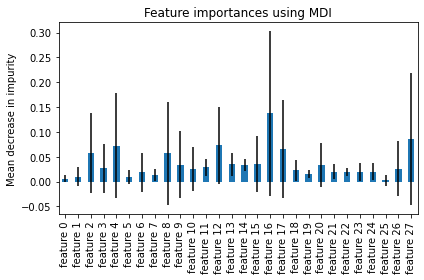

In [17]:
feature_names = [f"feature {i}" for i in range(X[0].shape[1])]
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
forest_importances = pd.Series(importances, index=feature_names)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

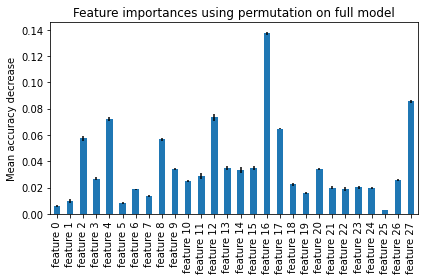

In [18]:
result = permutation_importance(
    clf, np.vstack(X_test), np.hstack(y_test), n_repeats=10, random_state=42, n_jobs=2
)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [19]:
# Train linear chain CRF
model = ChainCRF()
ssvm = FrankWolfeSSVM(model=model, C=.1, max_iter=20)
ssvm.fit(X_train, y_train)

print("Test score with chain CRF: %f" % ssvm.score(X_test, y_test))

preds = ssvm.predict(X_test)
correct_predictions(y_test, np.hstack(preds))

Test score with chain CRF: 0.888046
34/114 correct predictions!


In [20]:
ssvm = OneSlackSSVM(model=model, C=.1)
ssvm.fit(X_train, y_train)

print("Test score with chain CRF: %f" % ssvm.score(X_test, y_test))

preds = ssvm.predict(X_test)
correct_predictions(y_test, np.hstack(preds))

Test score with chain CRF: 0.888046
34/114 correct predictions!


In [21]:
ssvm = NSlackSSVM(model=model, C=.1)
ssvm.fit(X_train, y_train)

print("Test score with chain CRF: %f" % ssvm.score(X_test, y_test))

preds = ssvm.predict(X_test)
correct_predictions(y_test, np.hstack(preds))

Test score with chain CRF: 0.888046
34/114 correct predictions!


In [22]:
ssvm = StructuredPerceptron(model=model, max_iter=500)
ssvm.fit(X_train, y_train)

print("Test score with chain CRF: %f" % ssvm.score(X_test, y_test))

preds = ssvm.predict(X_test)
correct_predictions(y_test, np.hstack(preds))

Test score with chain CRF: 0.884250
29/114 correct predictions!
